In [1]:
# Load packages
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400 #high res figures
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import xgboost as xgb
import shap
import pickle

mpl.rcParams['figure.dpi'] = 400

In [2]:
with open('../../Data/xgb_model_w_data.pkl', 'rb') as f:
    features_response, X_train_all, y_train_all, X_test_all,\
    y_test_all, xgb_model_4 = pickle.load(f)

# Model Predictions and Performance on Test Set

In [3]:
test_set_pred_proba = xgb_model_4.predict_proba(X_test_all)[:,1]

In [4]:
deciles, decile_bin_edges = pd.qcut(x=test_set_pred_proba,
                                    q=10,
                                    retbins=True)
# pandas.qcut(x, q, labels=None, retbins=False, precision=3, duplicates='raise')

In [5]:
decile_bin_edges

array([0.02213463, 0.06000734, 0.08155108, 0.10424594, 0.12708404,
       0.15019046, 0.18111563, 0.23032923, 0.32210371, 0.52585585,
       0.89491451])

In [6]:
test_set_df = pd.DataFrame({'Predicted probability':test_set_pred_proba,
                            'Prediction decile':deciles,
                            'Outcome':y_test_all})
test_set_df.head()

,Predicted probability,Prediction decile,Outcome
0,0.544556,"(0.526, 0.895]",0
1,0.621311,"(0.526, 0.895]",0
2,0.049883,"(0.0211, 0.06]",0
3,0.890924,"(0.526, 0.895]",1
4,0.272326,"(0.23, 0.322]",0


In [7]:
test_set_gr = test_set_df.groupby('Prediction decile')
gr_df = test_set_gr.agg({'Outcome':['count', 'mean']})

In [8]:
gr_df

Outcome          
                    count      mean
Prediction decile                  
(0.0211, 0.06]        594  0.045455
(0.06, 0.0816]        594  0.070707
(0.0816, 0.104]       594  0.099327
(0.104, 0.127]        593  0.112985
(0.127, 0.15]         594  0.116162
(0.15, 0.181]         594  0.171717
(0.181, 0.23]         593  0.195616
(0.23, 0.322]         594  0.282828
(0.322, 0.526]        594  0.392256
(0.526, 0.895]        594  0.676768

In [9]:
gr_df.columns

MultiIndex([('Outcome', 'count'),
            ('Outcome',  'mean')],
           )

# Calibration

ECE metric https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4410090/

In [10]:
cal_df = test_set_gr.agg({'Outcome':['count', 'mean'],
                          'Predicted probability':'mean'})
cal_df

Outcome           Predicted probability
                    count      mean                  mean
Prediction decile                                        
(0.0211, 0.06]        594  0.045455              0.046931
(0.06, 0.0816]        594  0.070707              0.070745
(0.0816, 0.104]       594  0.099327              0.093163
(0.104, 0.127]        593  0.112985              0.115823
(0.127, 0.15]         594  0.116162              0.138657
(0.15, 0.181]         594  0.171717              0.165012
(0.181, 0.23]         593  0.195616              0.203106
(0.23, 0.322]         594  0.282828              0.273172
(0.322, 0.526]        594  0.392256              0.400159
(0.526, 0.895]        594  0.676768              0.693437

In [11]:
y_test_all.shape

(5938,)

In [12]:
F = cal_df[('Outcome', 'count')].values/y_test_all.shape[0]
F

array([0.10003368, 0.10003368, 0.10003368, 0.09986527, 0.10003368,
       0.10003368, 0.09986527, 0.10003368, 0.10003368, 0.10003368])

In [13]:
ECE = np.sum(
    F
    * np.abs(
             cal_df[('Outcome', 'mean')]
             - cal_df[('Predicted probability', 'mean')]))
ECE

0.008144502190176022

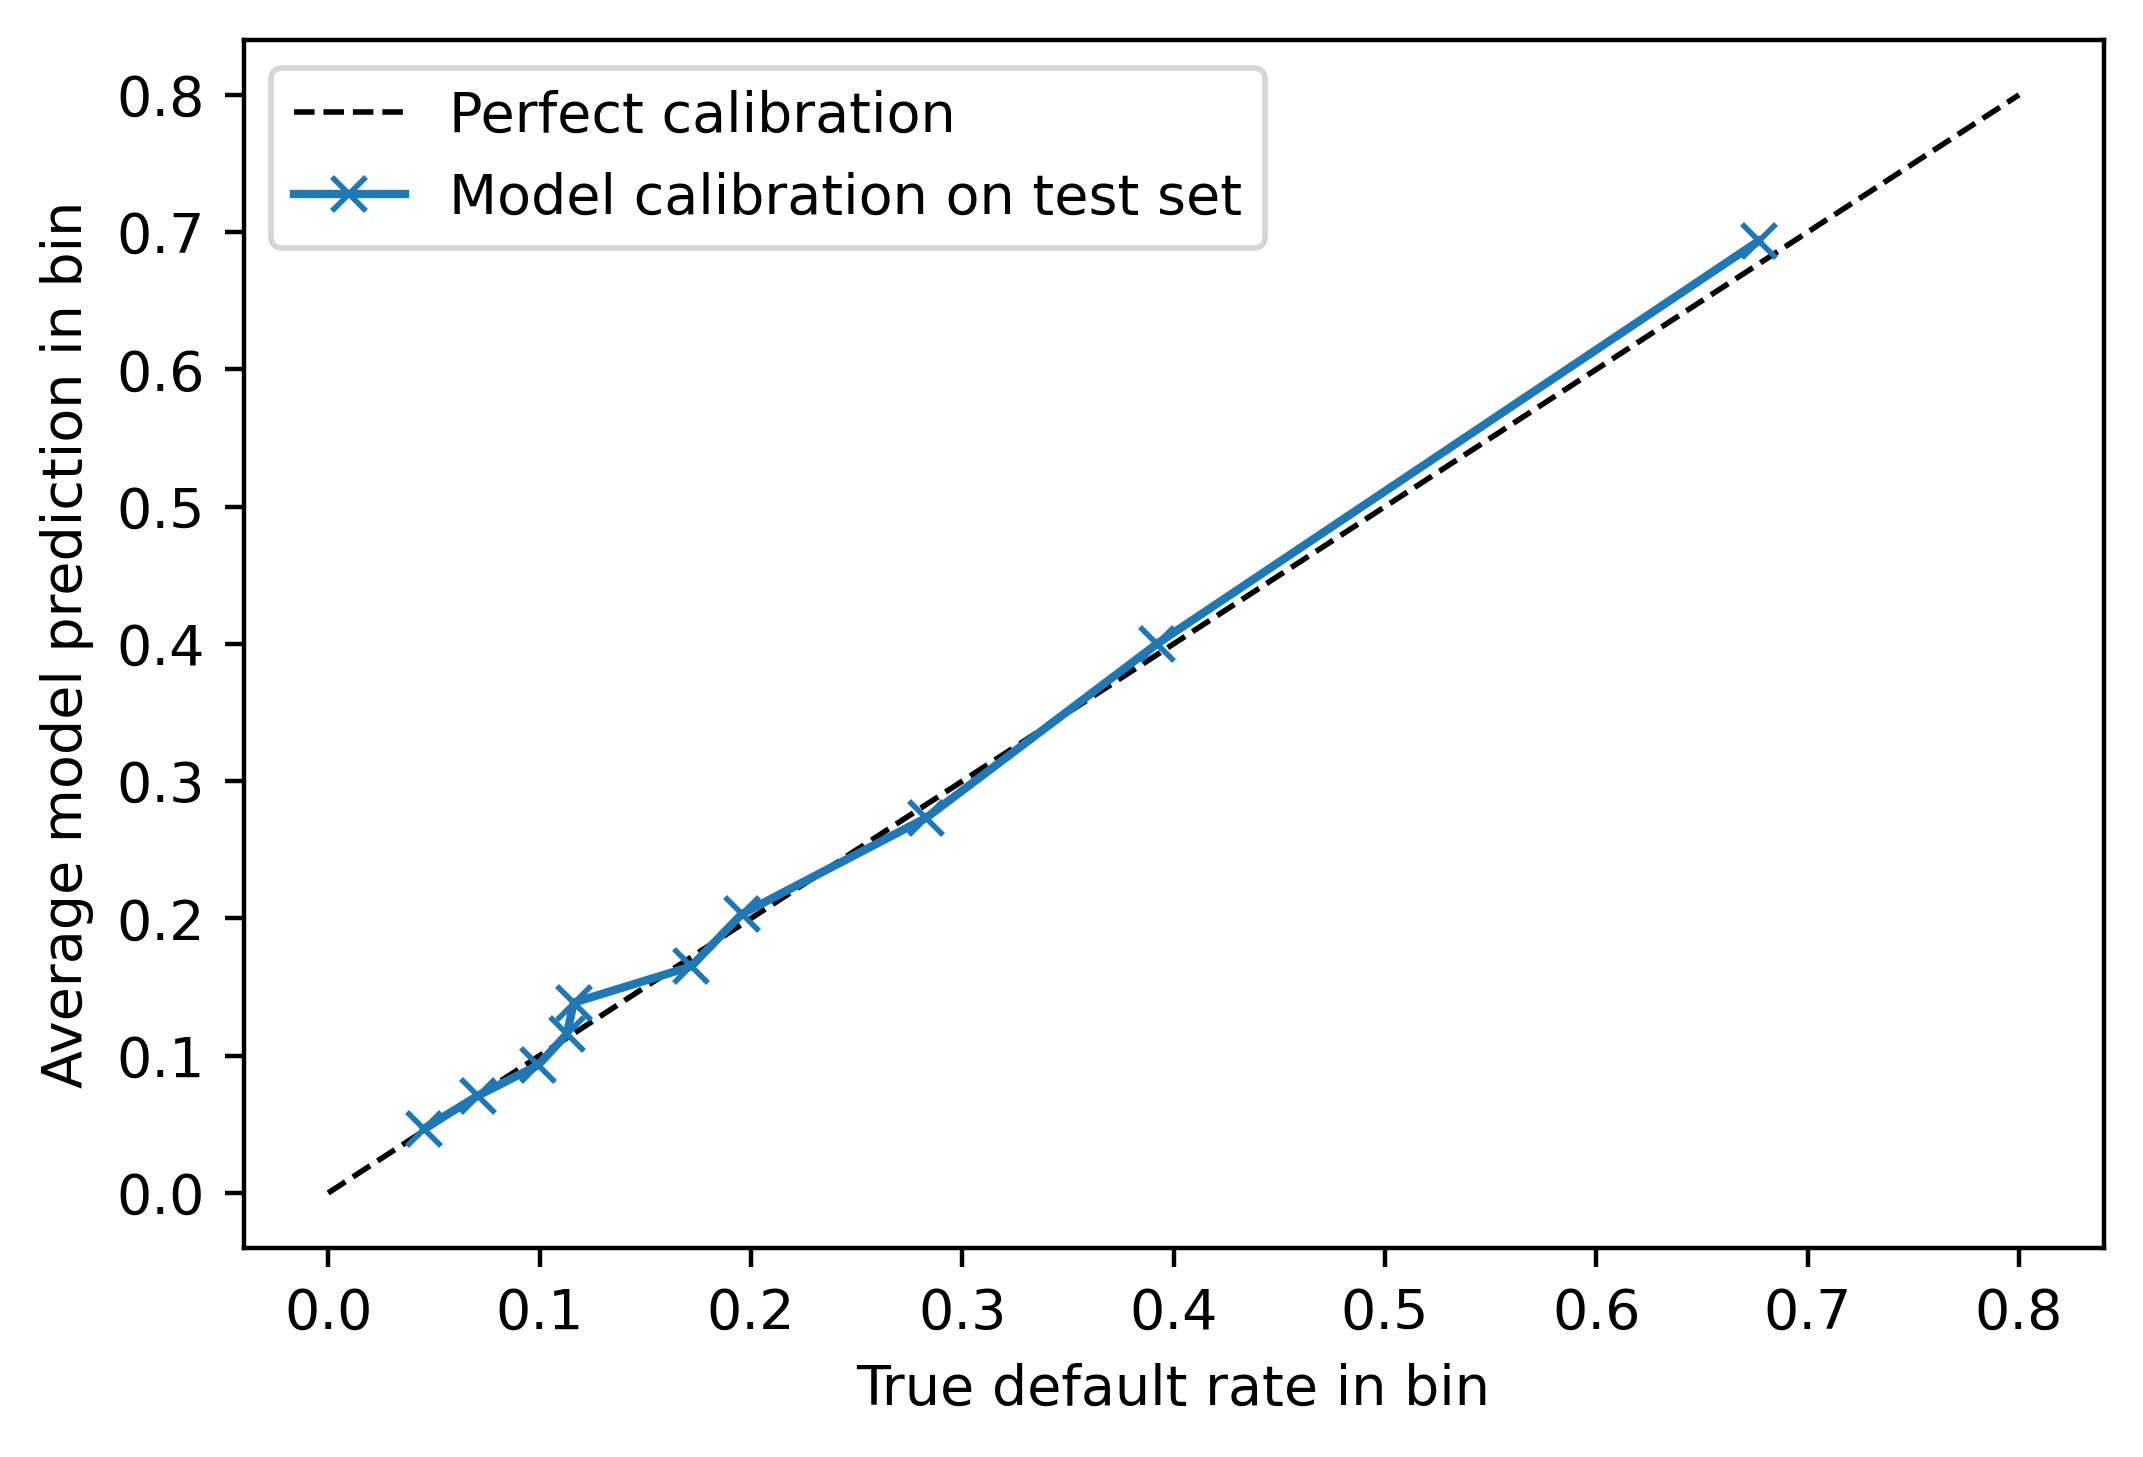

In [14]:
ax = plt.axes()
ax.plot([0, 0.8], [0, 0.8], 'k--', linewidth=1,
        label='Perfect calibration')
ax.plot(cal_df[('Outcome', 'mean')],
        cal_df[('Predicted probability', 'mean')],
        marker='x',
        label='Model calibration on test set')
ax.set_xlabel('True default rate in bin')
ax.set_ylabel('Average model prediction in bin')
ax.legend()

# Exercise 7.02: Characterizing Costs and Savings

In [15]:
thresholds = np.linspace(0, 1, 101)

In [16]:
features_response[5]

'BILL_AMT1'

In [17]:
cost_per_counseling = 7500

In [18]:
effectiveness = 0.70

In [19]:
n_pos_pred = np.empty_like(thresholds)
total_cost = np.empty_like(thresholds)
n_true_pos = np.empty_like(thresholds)
total_savings = np.empty_like(thresholds)
counter = 0
for threshold in thresholds:
    pos_pred = test_set_pred_proba > threshold
    n_pos_pred[counter] = sum(pos_pred)
    total_cost[counter] \
        = n_pos_pred[counter] * cost_per_counseling
    
    true_pos = pos_pred & y_test_all.astype(bool)
    n_true_pos[counter] = sum(true_pos)
    total_savings[counter] = np.sum(
        true_pos.astype(int)
        * X_test_all[:,5]
        * effectiveness
        )
    counter += 1

In [20]:
net_savings = total_savings - total_cost

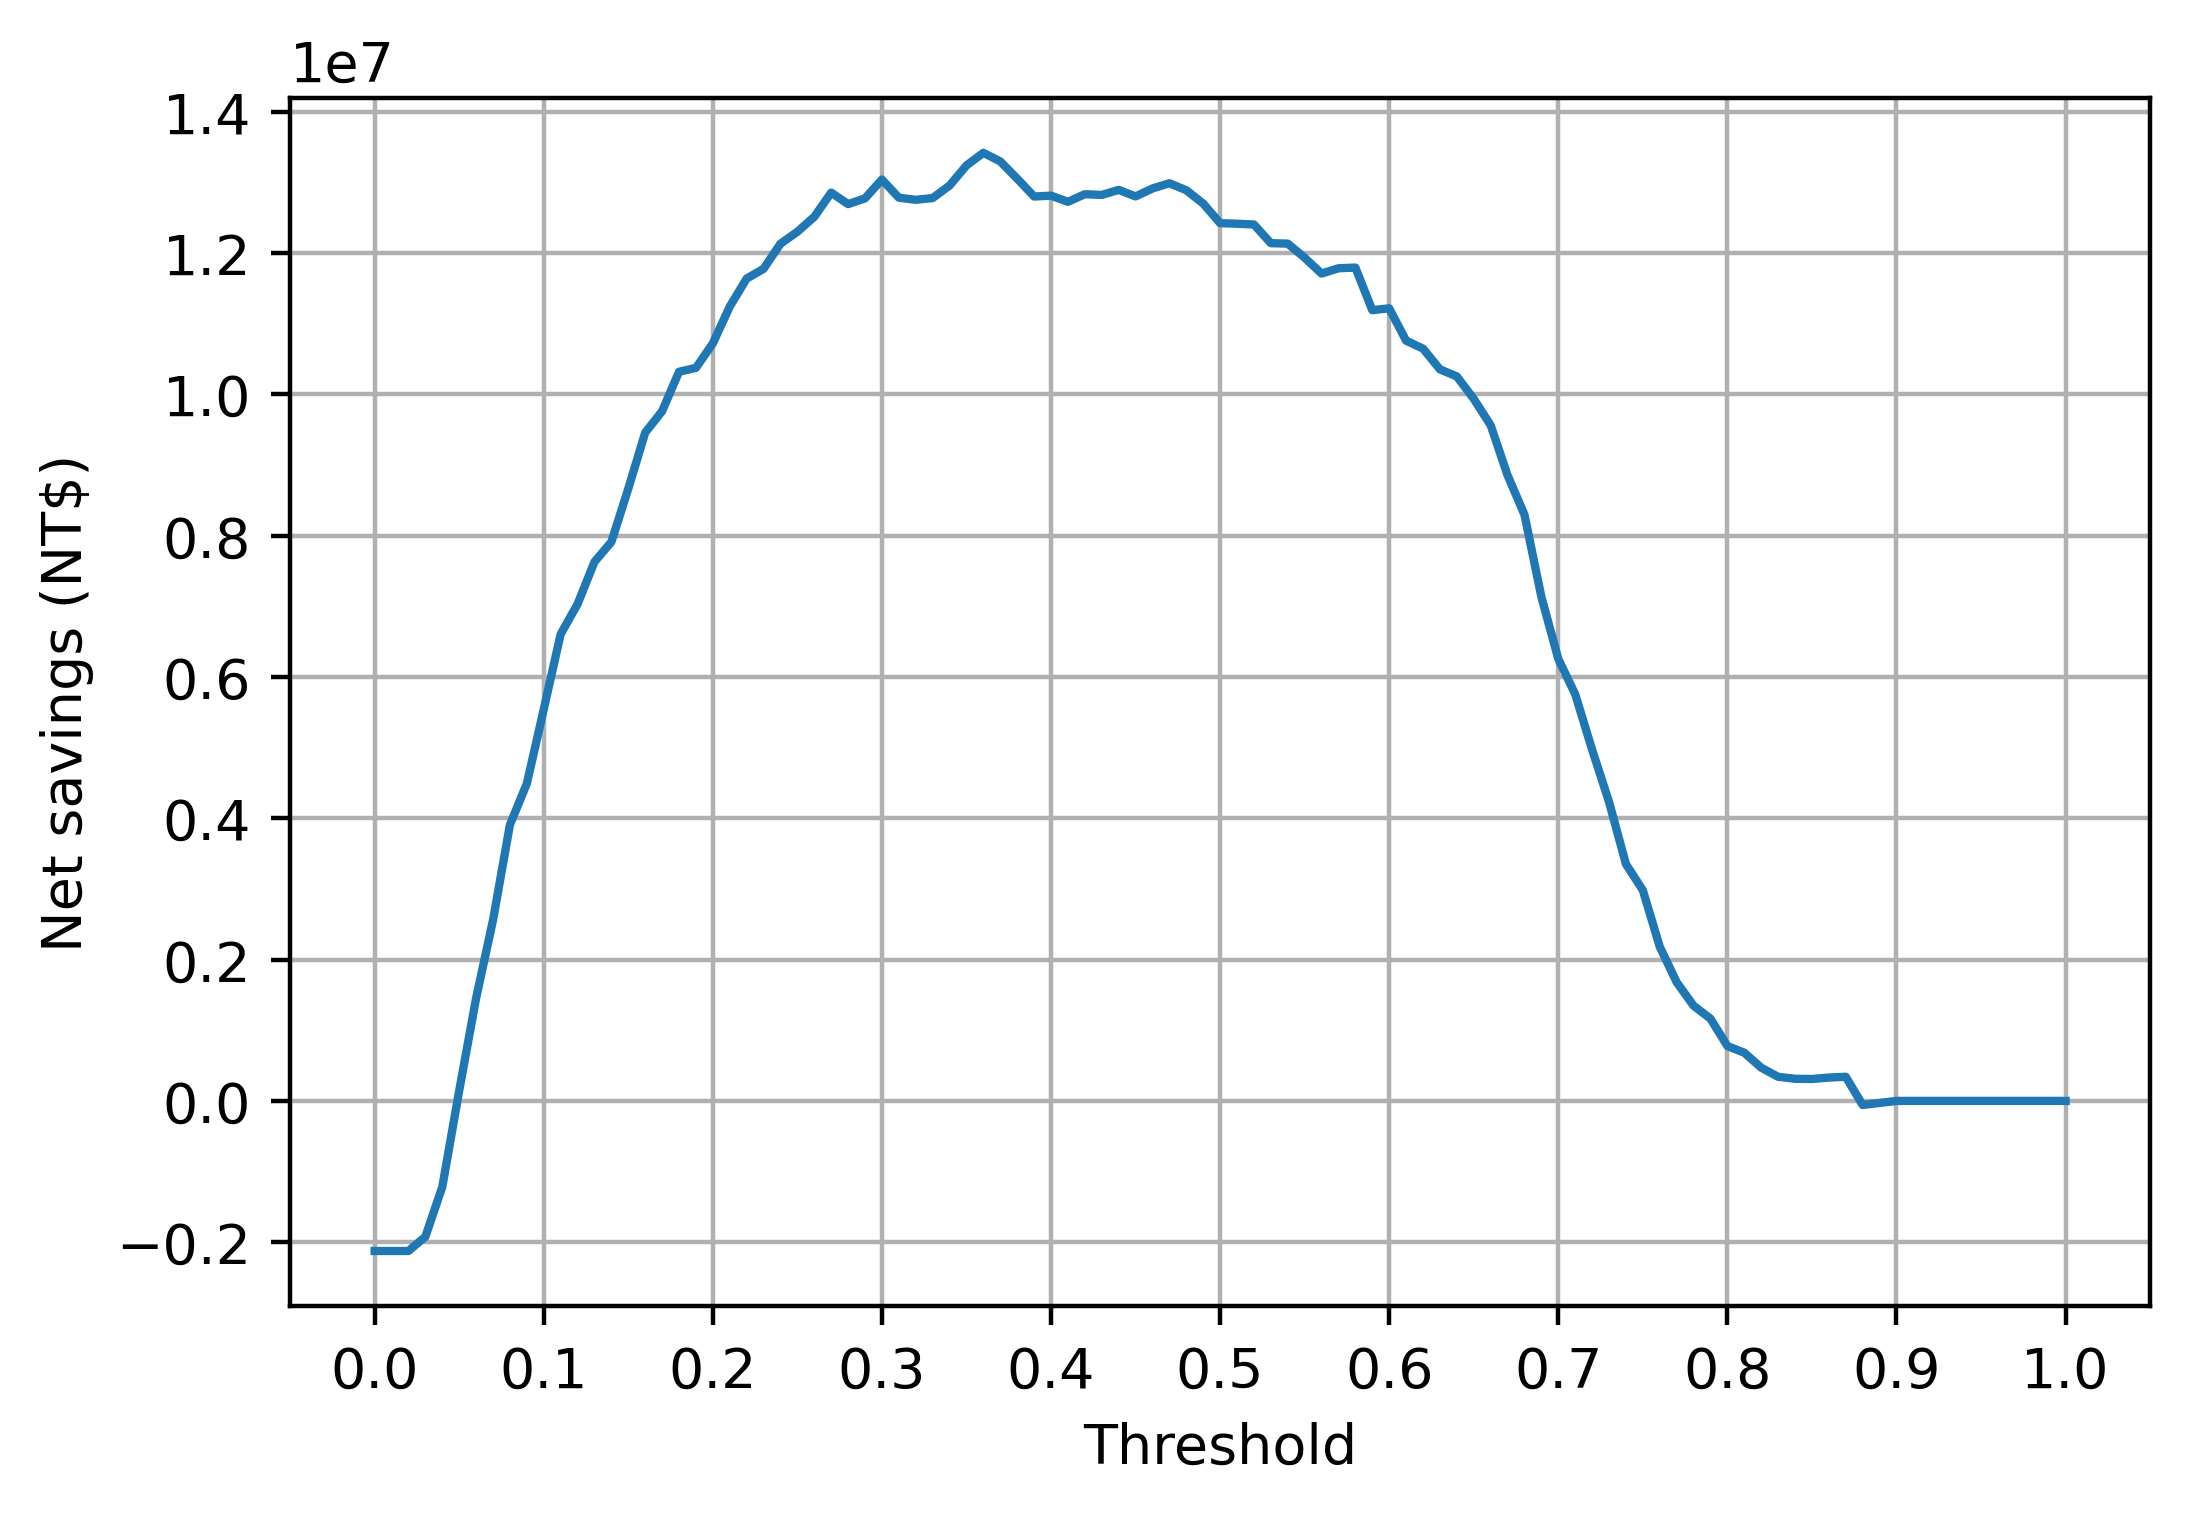

In [21]:
mpl.rcParams['figure.dpi'] = 400
plt.plot(thresholds, net_savings)
plt.xlabel('Threshold')
plt.ylabel('Net savings (NT$)')
plt.xticks(np.linspace(0,1,11))
plt.grid(True)

In [22]:
max_savings_ix = np.argmax(net_savings)

In [23]:
thresholds[max_savings_ix]
# 0.36

0.36

In [24]:
net_savings[max_savings_ix]
# 13415710.0

13415710.0